# Chapter 11: Neural nets

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [2]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
# import matplotlib.pyplot as plt 만 했을때 no display .. agg로 설정되는 경우 아래 실행
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import matplotlib.pyplot as plt

import dmba
from dmba import classificationSummary

%matplotlib inline

## Table 11.2

In [3]:
example_df = pd.read_csv('../data/TinyData.csv')

predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())

clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(X, y)
clf.predict(X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([
    example_df,
    pd.DataFrame(clf.predict_proba(X), columns=classes)
], axis=1))

Intercepts
[array([0.13368043, 4.07247549, 7.00768105]), array([14.30748672])]
Weights
[array([[ -1.3065648 ,  -4.20427796, -13.29587332],
       [ -0.04399729,  -4.91606922,  -6.03356987]]), array([[ -0.27348314],
       [ -9.01211575],
       [-17.63504687]])]
   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


In [4]:
# Pretty print layers
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()


Hidden layer 2 => 3
 Intercepts:
  [0.13368043 4.07247549 7.00768105]
 Weights:
  [ -1.3065648   -4.20427796 -13.29587332]
  [-0.04399729 -4.91606922 -6.03356987]

Output layer 3 => 1
 Intercepts:
  [14.30748672]
 Weights:
  [-0.27348314]
  [-9.01211575]
  [-17.63504687]



## Table 11.3

In [5]:
classificationSummary(y, clf.predict(X), class_names=classes)

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


## Table 11.6

In [6]:
accidents_df = pd.read_csv('../data/accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
# exclude the column for SUR_COND 9 = unknown
processed = pd.get_dummies(accidents_df, columns=['SUR_COND']).drop(columns=['SUR_COND_9'])

outcome = 'MAX_SEV_IR'
predictors = [c for c in processed.columns if c != outcome]

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y, clf.predict(train_X))

# validation performance
classificationSummary(valid_y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8664)

       Prediction
Actual   0   1   2
     0 331   0   1
     1   0 180   0
     2  30  49   8
Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


## Fitting class probabilities separately

In [7]:
accidents_df = pd.read_csv('../data/accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
processed = pd.get_dummies(accidents_df)
# drop the column for SUR_COND 9 = unknown
processed = processed.drop(columns=['SUR_COND_9'])

outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1, max_iter=500)
clf.fit(train_X, train_y)

# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(clf.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

# validation performance
validPrediction = pd.DataFrame(clf.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8731)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          170           10
MAX_SEV_IR_2           31           35           21
Confusion Matrix (Accuracy 0.8675)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          113            6
MAX_SEV_IR_2           24           22           16


## Grid search

In [8]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1, max_iter=500)
clf.fit(train_X, train_y.values)

param_grid = {
    'hidden_layer_sizes': [(1), (2), (3), (4), (5)], 
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=1000), 
                          param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.8630672268907563
Best parameters:  {'hidden_layer_sizes': 4}


In [9]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

  param_hidden_layer_sizes  mean_test_score  std_test_score
0                        1         0.844762        0.011030
1                        2         0.848067        0.009913
2                        3         0.861401        0.023566
3                        4         0.863067        0.024167
4                        5         0.856415        0.020770


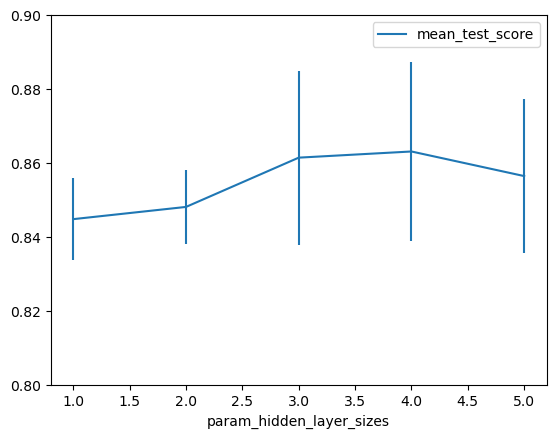

In [10]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))
plt.show()